## Estimation of standard deviation of CMB spectra residuals



### Load yaml file



In [1]:
import yaml
with open("residuals_covmat.yaml", "r") as stream:
    setup = yaml.load(stream)

### Generation of CMB spectrum



In [2]:
import numpy as np
# Get experiment setup
experiment = setup["experiment"]
lmin, lmax = experiment["lmin"], experiment["lmax"]

from beyondCV import utils
Dltt = utils.get_theory_cls(setup, lmax)
ls = np.arange(lmin, lmax)
Dl = Dltt[lmin:lmax]

No sampled parameters requested! This will fail for non-mock samplers.
Importing *global* CAMB.


Plot CMB spectrum



Text(0, 0.5, '$\\frac{\\ell(\\ell+1)}{2\\pi}\\,C_\\ell$ [$\\mu$K$^2$]')

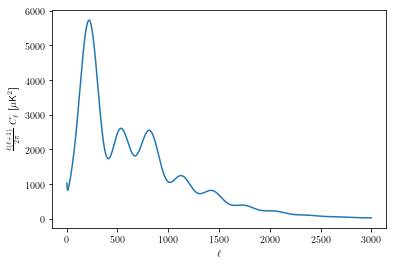

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
plt.plot(ls, Dl)
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\frac{\ell(\ell+1)}{2\pi}\,C_\ell$ [$\mu$K$^2$]")

### Get noise from experiment



In [4]:
freq_Planck, DNl_array_Planck = utils.get_noise(experiment, "Planck")
freq_Planck = list(freq_Planck)
freq_Planck.append("all")

freq_SO, DNl_array_SO = utils.get_noise(experiment, "SO")
freq_SO = list(freq_SO)
freq_SO.append("all")

ns = {}
DNl = {}
for freq in freq_Planck:
    key = "Planck_%s" % freq
    ns[key] = 2.
    DNl[key] = DNl_array_Planck[freq]*ns[key]

for freq in freq_SO:
    key = "SO_%s" % freq
    ns[key] = 10.
    DNl[key] = DNl_array_SO[freq]*ns[key]

### Compute covariance matrices



In [5]:
fsky = experiment["fsky"]
covmat_SSSS = utils.cov("SO_all", "SO_all", "SO_all", "SO_all", ns, ls, Dl, DNl, fsky)
covmat_SSSP = utils.cov("SO_all", "SO_all", "SO_all", "Planck_all", ns, ls, Dl, DNl, fsky)
covmat_SSPP = utils.cov("SO_all", "SO_all", "Planck_all", "Planck_all", ns, ls, Dl, DNl, fsky)
covmat_SPSP = utils.cov("SO_all", "Planck_all", "SO_all", "Planck_all", ns, ls, Dl, DNl, fsky)
covmat_SPPP = utils.cov("SO_all", "Planck_all", "Planck_all", "Planck_all", ns, ls, Dl, DNl, fsky)
covmat_PPPP = utils.cov("Planck_all", "Planck_all", "Planck_all", "Planck_all", ns, ls, Dl, DNl, fsky)

covmat_master = np.zeros((3,3,len(Dl)))
Dl_obs = np.zeros((3,len(Dl)))

covmat_master[0,0,:] = covmat_SSSS
covmat_master[0,1,:] = covmat_SSSP
covmat_master[0,2,:] = covmat_SSPP
covmat_master[1,0,:] = covmat_SSSP
covmat_master[1,1,:] = covmat_SPSP
covmat_master[1,2,:] = covmat_SPPP
covmat_master[2,0,:] = covmat_SSPP
covmat_master[2,1,:] = covmat_SPPP
covmat_master[2,2,:] = covmat_PPPP

Plot the `covmat`



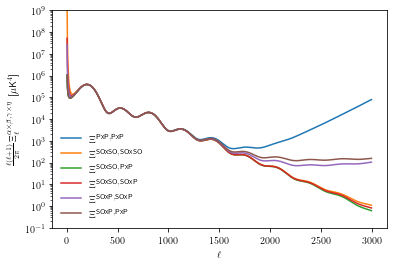

In [6]:
plt.semilogy()
plt.plot(ls, covmat_PPPP, label=r"$\Xi^{\sf PxP,PxP}$")
plt.plot(ls, covmat_SSSS, label=r"$\Xi^{\sf SOxSO,SOxSO}$")
plt.plot(ls, covmat_SSPP, label=r"$\Xi^{\sf SOxSO,PxP}$")
plt.plot(ls, covmat_SSSP, label=r"$\Xi^{\sf SOxSO,SOxP}$")
plt.plot(ls, covmat_SPSP, label=r"$\Xi^{\sf SOxP,SOxP}$")
plt.plot(ls, covmat_SPPP, label=r"$\Xi^{\sf SOxP,PxP}$")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\frac{\ell(\ell+1)}{2\pi}\Xi^{\alpha\times\beta,\gamma\times\eta}_\ell$ [$\mu$K$^4$]")
plt.ylim(0.1, 1e9)
plt.legend()

### Compute the covariance of the residuals



The covariance of the residual power spectrum can be computed as follow

\begin{align*}
  \mathcal{C}_1&= \langle (C^{\rm so \times so}_{\ell}-C^{\rm P \times P}_{\ell} )(C^{\rm so \times so}_{\ell}-C^{\rm P \times P}_{\ell} ) \rangle = \Xi^{\rm so \times so,so \times so}+  \Xi^{\rm P \times P,P \times P}- 2 \Xi^{\rm P \times P,so \times so}\\
  \mathcal{C}_2&= \langle (C^{\rm so \times P}_{\ell}-C^{\rm P \times P}_{\ell} )(C^{\rm so \times P}_{\ell}-C^{\rm P \times P}_{\ell} ) \rangle = \Xi^{\rm so \times P,so \times P}+  \Xi^{\rm P \times P,P \times P}- 2 \Xi^{\rm so \times P,P \times P}\\
  \mathcal{C}_3&= \langle (C^{\rm so \times P}_{\ell}-C^{\rm so \times so}_{\ell} )(C^{\rm so \times P}_{\ell}-C^{\rm so \times so}_{\ell} ) \rangle = \Xi^{\rm so \times P,so \times P}+  \Xi^{\rm so \times so,so \times so}- 2 \Xi^{\rm so \times P,so \times so}\\
  \mathcal{C}_4&= \langle (C^{\rm so \times so }_{\ell}+C^{\rm P \times P}_{\ell} - 2 C^{\rm so \times P }_{\ell} )(C^{\rm so \times so }_{\ell}+C^{\rm P \times P}_{\ell} - 2 C^{\rm so \times P }_{\ell} )\\
   &= \Xi^{\rm so \times so,so \times so} + \Xi^{\rm P \times P, P \times P} +  2\Xi^{\rm so \times so,P \times P} - 4  \Xi^{\rm so \times so,so \times P} - 4 \Xi^{\rm so \times P, P \times P} + 4 \Xi^{\rm so \times P, so \times P}
\end{align*}



In [7]:
C1 = covmat_SSSS + covmat_PPPP - 2*covmat_SSPP
C2 = covmat_SPSP + covmat_PPPP - 2*covmat_SPPP
C3 = covmat_SPSP + covmat_SSSS - 2*covmat_SSSP
C4 = covmat_SSSS + covmat_PPPP + 2*covmat_SSPP - 4*(covmat_SSSP+covmat_SPPP) + 4*covmat_SPSP

Plot covariances



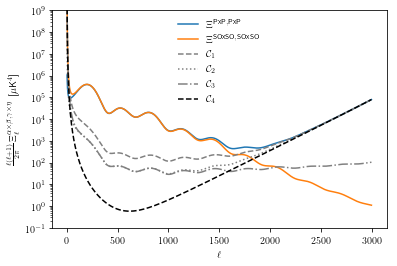

In [8]:
plt.semilogy()
plt.plot(ls, covmat_PPPP, label=r"$\Xi^{\sf PxP,PxP}$")
plt.plot(ls, covmat_SSSS, label=r"$\Xi^{\sf SOxSO,SOxSO}$")
plt.plot(ls, C1, color="0.5", linestyle="dashed", label=r"$\mathcal{C}_1$")
plt.plot(ls, C2, color="0.5", linestyle="dotted", label=r"$\mathcal{C}_2$")
plt.plot(ls, C3, color="0.5", linestyle="dashdot", label=r"$\mathcal{C}_3$")
plt.plot(ls, C4, color="k",   linestyle="dashed", label=r"$\mathcal{C}_4$")
plt.ylim(0.1, 1e9)
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\frac{\ell(\ell+1)}{2\pi}\Xi^{\alpha\times\beta,\gamma\times\eta}_\ell$ [$\mu$K$^4$]")
plt.legend()

### Simulate variances of the residuals



In [9]:
for i in range(len(Dl)):
    mat = utils.svd_pow(covmat_master[:,:,i],1./2)
    Dl_obs[:,i] = Dl[i] + np.dot(mat, np.random.randn(3))

Dl_obs_SxS, Dl_obs_SxP, Dl_obs_PxP = Dl_obs[0,:], Dl_obs[1,:], Dl_obs[2,:]

Plot the resulting CMB spectra



Text(0.5, 0, '$\\ell$')

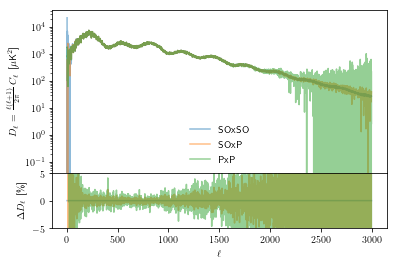

In [10]:
grid = plt.GridSpec(4, 1, hspace=0, wspace=0)
main = plt.subplot(grid[0:3], xticklabels=[])
main.semilogy()
main.plot(ls, Dl_obs_SxS, label="SOxSO",alpha=0.5)
main.plot(ls, Dl_obs_SxP, label="SOxP",alpha=0.5)
main.plot(ls, Dl_obs_PxP, label="PxP",alpha=0.5)
main.set_ylabel(r"$D_\ell=\frac{\ell(\ell+1)}{2\pi}\,C_\ell$ [$\mu$K$^2$]")
main.legend()
dev = plt.subplot(grid[3], ylim=[-5,5])
dev.plot(ls, 100*(1 - Dl_obs_SxS/Dl_obs_SxS), alpha=0.5)
dev.plot(ls, 100*(1 - Dl_obs_SxP/Dl_obs_SxS), alpha=0.5)
dev.plot(ls, 100*(1 - Dl_obs_PxP/Dl_obs_SxS), alpha=0.5)
dev.set_ylabel(r"$\Delta D_\ell$ [\%]")
dev.set_xlabel(r"$\ell$")

Compute variances of the residuals



In [11]:
nbr_sims = 100
Dl_SSmPP = np.empty((nbr_sims, len(Dl)))
Dl_SSmSP = np.empty((nbr_sims, len(Dl)))
Dl_SPmPP = np.empty((nbr_sims, len(Dl)))
Dl_SSpPPm2SP = np.empty((nbr_sims, len(Dl)))

for n in range(nbr_sims):
    for i in range(len(Dl)):
        mat = utils.svd_pow(covmat_master[:,:,i],1./2)
        Dl_obs[:,i] = Dl[i] + np.dot(mat, np.random.randn(3))

    Dl_obs_SxS, Dl_obs_SxP, Dl_obs_PxP = Dl_obs[0,:], Dl_obs[1,:], Dl_obs[2,:]
    Dl_SSmPP[n,:] = Dl_obs_SxS - Dl_obs_PxP
    Dl_SSmSP[n,:] = Dl_obs_SxS - Dl_obs_SxP
    Dl_SPmPP[n,:] = Dl_obs_SxP - Dl_obs_PxP
    Dl_SSpPPm2SP[n,:] = Dl_obs_SxS + Dl_obs_PxP - 2*Dl_obs_SxP

Plot variance of residuals



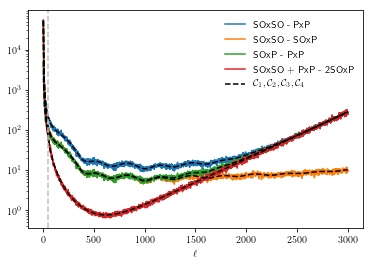

In [12]:
plt.semilogy()
plt.plot(ls, np.std(Dl_SSmPP, axis=0), label="SOxSO - PxP")
plt.plot(ls, np.std(Dl_SSmSP, axis=0), label="SOxSO - SOxP")
plt.plot(ls, np.std(Dl_SPmPP, axis=0), label="SOxP - PxP")
plt.plot(ls, np.std(Dl_SSpPPm2SP, axis=0), label="SOxSO + PxP - 2SOxP")
plt.plot(ls, np.sqrt(C1), color="k", linestyle="dashed",
         label=r"$\mathcal{C}_1, \mathcal{C}_2, \mathcal{C}_3, \mathcal{C}_4$")
plt.plot(ls, np.sqrt(C2), color="k", linestyle="dashed")
plt.plot(ls, np.sqrt(C3), color="k", linestyle="dashed")
plt.plot(ls, np.sqrt(C4), color="k", linestyle="dashed")
plt.xlabel(r"$\ell$")
plt.axvline(50, color="0.75", linestyle="dashed")
plt.legend()